## TASK 1: DATA PREPARATION (30 POINTS)
The first phase of a Data Mining project typically includes getting familiar with the domain and pre-processing the dataset in a suitable manner. In this part of the assignment, we will go through those steps.

### TASK 1A: EXPLORATORY DATA ANALYSIS (10 POINTS)
Start with exploring the raw data that is available: \
• Notice all sorts of properties of the dataset: how many records are there, how many
attributes, what kinds of attributes are there, ranges of values, distribution of values,
relationships between attributes, missing values, and so on. A table is often a suitable
way of showing such properties of a dataset. Notice if something is interesting (to you,
or in general), make sure you write it down if you find something worth mentioning. \
• Make various plots of the data. Is there something interesting worth reporting? Report the figures, discuss what is in them. What meaning do those bars, lines, dots, etc.
convey? Please select essential and interesting plots for discussion, as you have limited
space for reporting your findings.

In [11]:
# Import libraries
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import numpy as np
import pandas as pd

from Preprocessing.preprocessing import remove_outliers, print_z_score_limits

In [12]:
# Import as Dataframe
df = pd.read_csv('./Data/dataset_mood_smartphone.csv')
df.head()

# Drop unnecessary columns
data =  df.drop(['Unnamed: 0'], axis=1)
    
# Make sure the 'time' column is of type datetime
data['time'] = pd.to_datetime(data['time'])

In [14]:
# Inspect the dataset
print(f"Number of records: {len(data)}")
print(f"Number of attributes: {len(data.columns)}")
print(f"Attribute types:\n{data.dtypes}")
print(f"Ranges of values:\n{data['value'].describe()}")

Number of records: 376912
Number of attributes: 4
Attribute types:
id                  object
time        datetime64[ns]
variable            object
value              float64
dtype: object
Ranges of values:
count    376710.000000
mean         40.665313
std         273.726007
min      -82798.871000
25%           2.025000
50%           7.029000
75%          29.356000
max       33960.246000
Name: value, dtype: float64


In [15]:
# Check for missing values
print(f"Number of missing values:\n{data.isnull().sum()}") # 202 missing values in the 'value' column

# Generate descriptive statistics for the dataset
print(data.describe())

# Counts of values recorded per month
pd.to_datetime(data["time"]).dt.to_period('M').value_counts().sort_index()

Number of missing values:
id            0
time          0
variable      0
value       202
dtype: int64
                                time          value
count                         376912  376710.000000
mean   2014-04-16 05:01:16.959544064      40.665313
min       2014-02-17 07:00:52.197000  -82798.871000
25%              2014-04-03 15:00:00       2.025000
50%    2014-04-15 22:13:12.874500096       7.029000
75%    2014-04-27 19:25:38.207000064      29.356000
max              2014-06-09 00:00:00   33960.246000
std                              NaN     273.726007


time
2014-02      1102
2014-03     73620
2014-04    233483
2014-05     66808
2014-06      1899
Freq: M, Name: count, dtype: int64

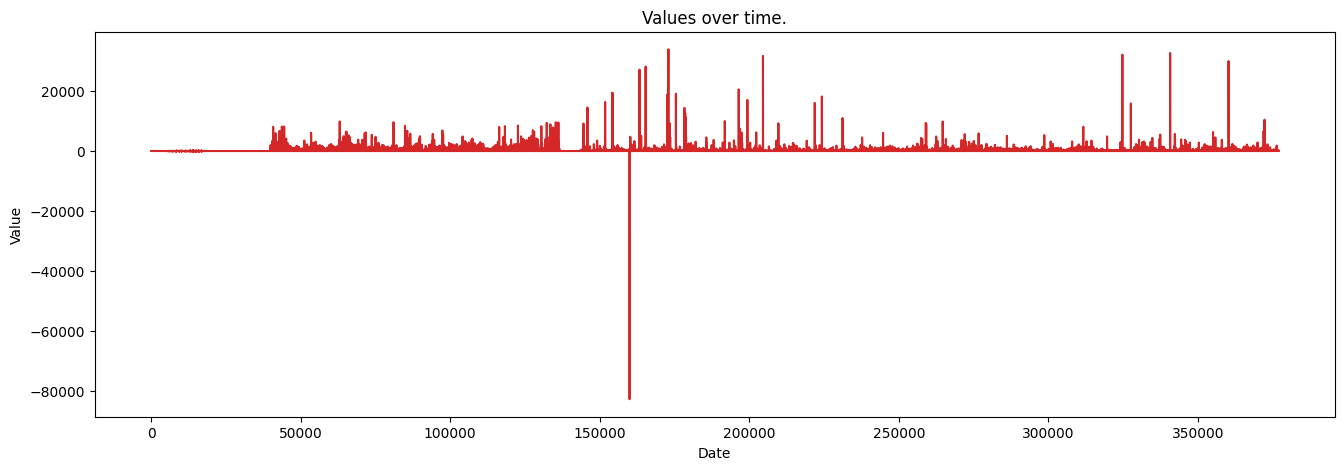

In [16]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(data, x = data.index, y = data.value, title='Values over time.')    


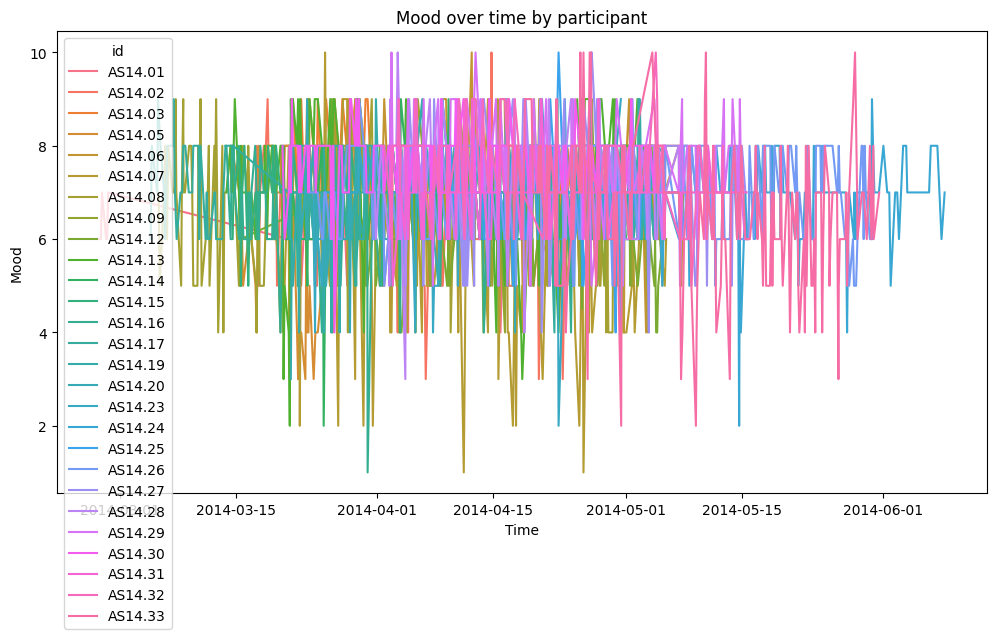

In [17]:
# Create line plot of mood variable over time for each participant
plt.figure(figsize=(12, 6))
sns.lineplot(x='time', y='value', data=data[data['variable'] == 'mood'], hue='id')
plt.title('Mood over time by participant')
plt.xlabel('Time')
plt.ylabel('Mood')
plt.show()

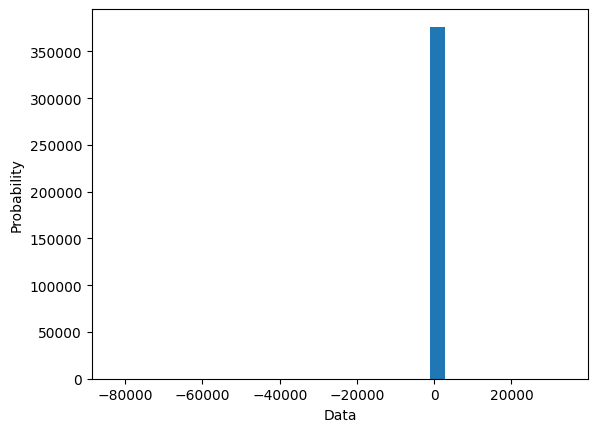

In [18]:
# Data not normally distributed, a lot of extreme values
# Show histograms - all variables except for the identifier variables
plt.hist(np.array(data['value'].tolist()).astype('float'), density=False, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data')
plt.show()


### TASK 1B: DATA CLEANING (10 POINTS)
As the insights from Task 1A will have shown, the dataset you analyze contains quite some
noise. Values are sometimes missing, and extreme or incorrect values are seen that are likely
outliers you may want to remove from the dataset. We will clean the dataset in two steps: \
• Apply an approach to remove extreme and incorrect values from your dataset. Describe
what your approach is, why you consider that to be a good approach, and describe what
the result of applying the approach is. \
• Impute the missing values using two different approaches. Describe the approaches
and study the impact of applying them to your data. Argue which one of the two approaches would be most suitable and select that one to form your cleaned dataset. Also
base yourself on scientific literature for making your choice.
Advanced: The advanced dataset contains a number of time series, select approaches to impute missing values that are logical for such time series. Also consider what to do with prolonged periods of missing data in a time series.

(1694, 4)


/Users/gast/Desktop/datamijnen/venv/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


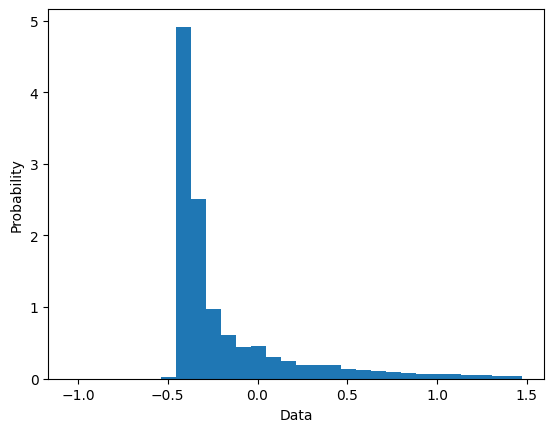

In [19]:
# Outlier removal based on Z-score solely (NOT GOOD BECAUSE NOT NORMALLY DISTRIBUTED)
# Print the upper and lower limits
print_z_score_limits(data, "value")
'Variable Name: value | Upper limit: 861.84 | Lower limit: -780.51'

# Filter outliers
sample_z = data[(data['value'] >= 861.84) | (data['value'] <= -780.51)]
print(sample_z.shape) # (1694, 4) --> 1694 outliers according to Z-score

# Outlier removal based on IQR
c_data = remove_outliers(data)

# Density plot of the cleaned data after outlier removal
plt.hist(np.array(c_data['value'].tolist()).astype('float'), density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data')
plt.show()